<a href="https://colab.research.google.com/github/uwtintres/robotic_surgeries/blob/main/TOPSIS_with_AHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project is the work of Alina Saduova, CSS graduate student at UWT, Spring'21. This notebook is used for the TOPSIS algorithm with combintaion of AHP algorithm to calculate weights. The processing is done according to the next steps:

1. Load .xlsx file where the importance of the attributes to each other is provided according to the following scale:


> **Importance**: 
*  1 - equal importance
*  3 - moderate importance
*  5 - strong importance
*  7 - very strong importance
*  9 - extremely strong importance

To elaborate, if we compare the drinks consumption among people, the table would look like:

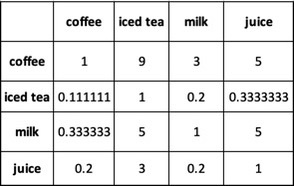

As you can observe, the relation of the same attribute to itself will have rank 1 (equal importance). Also, as coffee consumption is much more than that of iced tea, the rank is 9, meaning coffee has extremely strong importance compared to iced tea. The other drinks were ranked accordingly. 

The input .xlsx file should have similar table with rankings provided.
2. Load the main .xlsx file that was used for TOPSIS with custom weights.
3. Processing of the first input file to calculate the weight of each attribute.
4. Check if the table is consistent. At this step, the consistency of the table is checked, where the calculated value should be less than 0.1. If it is greater, the algorithm should start from step 1 again, where user needs to rank the importance in a different way and reload the file. 
5. The consistency check is passed, save the calculated weights.
6. Provide the calculated weights and the main table to the TOPSIS algorithm to rank the alternatives.

**Visualizing the results.**
The calculated weights values are printed for visualization purposes along with the consistency value, if the value is > 0.1, the user is notified that ranking should be rearranged. 


In [17]:
import numpy as np
def calcSum(ranks):
  # sums of the ranks along the column
  sums = [0] * len(ranks)
  curSum = 0
  for col in range(len(ranks)):
    for row in range(len(ranks)):
      curSum += ranks[row][col]
    sums[col] = curSum
    curSum = 0
  return sums

def calcWeights(ranks, sums):
  newMatrix = np.copy(ranks)
  criteria_weights = [0] * len(ranks)
  weightedMatrix = np.copy(ranks)
  lambdas = [0] * len(ranks)
  # random index is hard coded value to calculate the consistency ration later
  random_index = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]

  for col in range(len(ranks)):
    for row in range(len(ranks)):
      newMatrix[row][col] /= sums[col]
  print('Step 1:\n', newMatrix)

  # The weights are calculated at step two, but the matrix should be checked 
  # before passing the weights
  for row in range(len(ranks)):
    criteria_weights[row] = sum(newMatrix[row][:]) / len(ranks)
  print('\nStep 2. Criteria weights:\n', criteria_weights)

  for col in range(len(ranks)):
    for row in range(len(ranks)):
      weightedMatrix[row][col] = ranks[row][col] * criteria_weights[col]
  print('\nStep 3. Weighted matrix:\n', weightedMatrix)
  
  for row in range(len(ranks)):
    lambdas[row] = sum(weightedMatrix[row][:]) / criteria_weights[row]
  print('\nLambda values:\n', lambdas)

  # Calculating the consistency index and ration according to the lambda values
  lambdamax = sum(lambdas) / len(lambdas)
  consistency_index = (lambdamax - len(lambdas)) / (len(lambdas) - 1)
  consistency_ratio = consistency_index / random_index[len(lambdas)-1]
  print('\nConsistency ratio: ', consistency_ratio)

  # Checking the consistency of the matrix
  if consistency_ratio < 0.1:
    print('Matrix is consistent.\n') 
    return criteria_weights
  else:
    print('Matrix is inconsistent, redo the ranking')
    return 

def calcAHP(ranks):
  sums = calcSum(ranks)
  return calcWeights(ranks, sums)


The TOPSIS algorithm is imported here to calculate the final rankings according to the weights calculated above. 

In [18]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

class Topsis():
    evaluation_matrix = np.array([])  # Matrix
    weighted_normalized = np.array([])  # Weight matrix
    normalized_decision = np.array([])  # Normalisation matrix
    M = 0  # Number of rows
    N = 0  # Number of columns

    '''
	Create an evaluation matrix consisting of m alternatives and n criteria.
	  '''

    def __init__(self, evaluation_matrix, weight_matrix, criteria):
        # M×N matrix
        self.evaluation_matrix = np.array(evaluation_matrix, dtype="float")

        # M alternatives (options)
        self.row_size = len(self.evaluation_matrix)

        # N attributes/criteria
        self.column_size = len(self.evaluation_matrix[0])

        # N size weight matrix
        self.weight_matrix = np.array(weight_matrix, dtype="float")
        self.weight_matrix = self.weight_matrix/sum(self.weight_matrix)
        self.criteria = np.array(criteria, dtype="float")

    '''
	# Step 2
	The matrix  is then normalised.
	'''

    def step_2(self):
        # normalized scores
        self.normalized_decision = np.copy(self.evaluation_matrix)
        sqrd_sum = np.zeros(self.column_size)
        for i in range(self.row_size):
            for j in range(self.column_size):
                sqrd_sum[j] += self.evaluation_matrix[i, j]**2
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.normalized_decision[i,
                                         j] = self.evaluation_matrix[i, j]/(sqrd_sum[j]**0.5)

    '''
	# Step 3
	Calculate the weighted normalised decision matrix
	'''

    def step_3(self):
        from pdb import set_trace
        self.weighted_normalized = np.copy(self.normalized_decision)
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.weighted_normalized[i, j] *= self.weight_matrix[j]

    '''
	# Step 4
	Determine the ideal worst alternative and the ideal best alternative:
	'''

    def step_4(self):
        self.worst_alternatives = np.zeros(self.column_size)
        self.best_alternatives = np.zeros(self.column_size)
        for i in range(self.column_size):
            if self.criteria[i]:
                self.worst_alternatives[i] = min(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = max(self.weighted_normalized[:, i])
            else:
                self.worst_alternatives[i] = max(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = min(self.weighted_normalized[:, i])

    '''
	# Step 5
	Calculate the L2-distance between the target alternative with the ideal worst 
  value and the ideal best value.
	'''

    def step_5(self):
        self.worst_distance = np.zeros(self.row_size)
        self.best_distance = np.zeros(self.row_size)

        self.worst_distance_mat = np.copy(self.weighted_normalized)
        self.best_distance_mat = np.copy(self.weighted_normalized)

        for i in range(self.row_size):
            for j in range(self.column_size):
                self.worst_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.worst_alternatives[j])**2
                self.best_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.best_alternatives[j])**2
                
                self.worst_distance[i] += self.worst_distance_mat[i][j]
                self.best_distance[i] += self.best_distance_mat[i][j]

        for i in range(self.row_size):
            self.worst_distance[i] = self.worst_distance[i]**0.5
            self.best_distance[i] = self.best_distance[i]**0.5

    '''
	# Step 6
	Calculate the preformance score
	'''

    def step_6(self):
        np.seterr(all='ignore')
        self.preformance_score = np.zeros(self.row_size)

        for i in range(self.row_size):
            # calculate the similarity to the worst condition
            self.preformance_score[i] = self.worst_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])
    
    def ranking(self, data):
        return [i+1 for i in np.argsort(-1*data)]

    def rank_to_preformance_score(self):
        return self.ranking(self.preformance_score)

    def visualization(self, ranking):
        #ax = fig.add_axes([0,0,1,1])
        axes = []
        for i, rank in enumerate(ranking):
          axes.append(((rank), (i + 1)))
        axes.sort(key=lambda x: x[0])
        x_axis,y_axis = ['A' + str(val[0]) for val in axes],[val[1] for val in axes]
        plt.figure(figsize=(12, 6))
        ax = pd.Series(y_axis).plot(kind='bar')
        ax.set_xticklabels(x_axis)

        rects = ax.patches
        for rect, label in zip(rects, y_axis):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
        ax.bar(x_axis,y_axis)

    def calc(self):
        print("Step 1\n", self.evaluation_matrix, end="\n\n")
        self.step_2()
        print("Step 2\n", self.normalized_decision, end="\n\n")
        self.step_3()
        print("Step 3\n", self.weighted_normalized, end="\n\n")
        self.step_4()
        print("Step 4\n", self.worst_alternatives,
              self.best_alternatives, end="\n\n")
        self.step_5()
        print("Step 5\n", self.worst_distance, self.best_distance, end="\n\n")
        self.step_6()
        print("Step 6\n", self.preformance_score, end="\n\n")
        

Driver code is provied below, where two files are used, one for calculating the weights and the second is the main file for the ranking calculation from the attributes and alternatives provided. 

The weights are then calculated by the above AHP algorithm and used for the TOPSIS algorithm. The output of this part of the code is the step by step illustration of the AHP weights calculation with the summary of the weights, input matrix and criterias at the end.

In [ ]:
import numpy as np
import pandas as pd 

xl = pd.read_excel("AHP Importance.xlsx", sheet_name="Beginning", 
                   usecols=range(1, len(xl.columns)+1))

xl2 = pd.read_excel("TOPSIS with custom weights.xlsx", sheet_name="Beginning", 
                   usecols=range(1, len(xl2.columns)+1))

# initializing input matrix, weights, criterias
topsis_input_matrix = xl2.tail(n=len(xl2.index) - 2).values.tolist()
criterias = xl2.head(n=0).columns.values
ahp_input_matrix = xl.values.tolist()
print('AHP steps:\n')
weights = calcAHP(ahp_input_matrix)

new_criterias = []
for criteria in criterias:
  # if the attribute is non beneficiary, meaning min value is better -> False, 
  # otherwise, the criteria is True
  new_criterias.append(False if criteria[0] == 'N' else True)

print('TOPSIS input matrix: ', topsis_input_matrix)
print('weights: ', weights)
print('criterias: ', new_criterias)

Afterwards, the TOPSIS algorithm is called to calculate the rankings, where step by step execution is provided at the output. It could also be observed from the visualization graph below that the results coincide with the weights of each alternative. Meaning the attribute that bares the bigger weight and the alternatives who's values for this attribute fit better are ranked higher. 

TOPSIS steps:
Step 1
 [[  21.  300.   90.   60.]
 [  45.  800.   74.   30.]
 [  64.  700.   12.   90.]
 [  86. 1000.   36.   10.]
 [  75.  100.   24.    5.]
 [  34. 1200.   47.   23.]
 [  56.  400.   55.   67.]
 [  90.  350.   67.   84.]
 [  60.  580.   74.   75.]
 [  70.  460.   86.   98.]
 [  80.  220.   98.   46.]
 [  10.  900.   40.   15.]]

Step 2
 [[0.09689155 0.12959356 0.40496603 0.29149234]
 [0.20762475 0.34558283 0.33297207 0.14574617]
 [0.29528853 0.30238498 0.05399547 0.43723851]
 [0.39679396 0.43197854 0.16198641 0.04858206]
 [0.34604125 0.04319785 0.10799094 0.02429103]
 [0.15687203 0.51837425 0.21148226 0.11173873]
 [0.25837746 0.17279142 0.24747924 0.32549978]
 [0.4152495  0.15119249 0.30147471 0.40808927]
 [0.276833   0.25054755 0.33297207 0.36436542]
 [0.32297183 0.19871013 0.38696754 0.47610415]
 [0.36911066 0.09503528 0.44096302 0.22347746]
 [0.04613883 0.38878069 0.1799849  0.07287308]]

Step 3
 [[0.02162347 0.07601522 0.05095278 0.01878431]
 [0.04633601 0.20270726

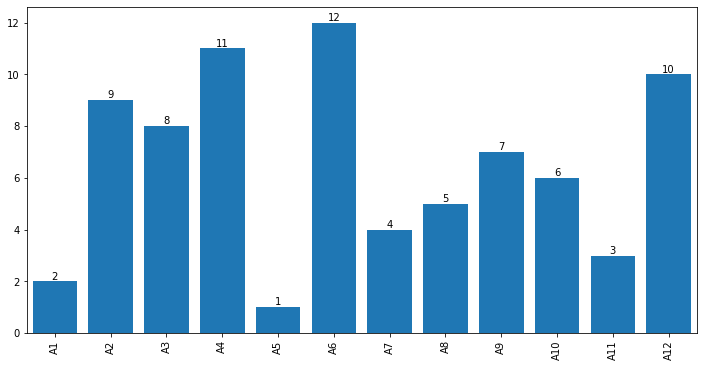

In [27]:
print('TOPSIS steps:')
t = Topsis(topsis_input_matrix, weights, new_criterias)

# calculating the ranking
t.calc()

ranks = t.rank_to_preformance_score()

print("Visualization graph:")
t.visualization(ranks)  